In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

from sklearn.linear_model import LinearRegression

import theano
import pymc3 as pm
from pymc3 import plot_posterior

%matplotlib inline

/Users/sachin/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [ ]:
%%capture
%%bash
mkdir data/
wget -P ./data/ https://github.com/sachinruk/bayes_school/raw/master/data/all_stocks_5yr.csv.zip 

The data was downloaded from https://www.kaggle.com/camnugent/sandp500

In [2]:
df = pd.read_csv('./data/all_stocks_5yr.csv.zip', compression='zip')
df.head()

,Date,Open,High,Low,Close,Volume,Name
0,2012-08-13,92.29,92.59,91.74,92.40,2075391.0,MMM
1,2012-08-14,92.36,92.50,92.01,92.30,1843476.0,MMM
2,2012-08-15,92.00,92.74,91.94,92.54,1983395.0,MMM
3,2012-08-16,92.75,93.87,92.21,93.74,3395145.0,MMM
4,2012-08-17,93.93,94.30,93.59,94.24,3069513.0,MMM


In [7]:
sandp500 = pd.read_csv('./data/sandp500.csv')
sandp500['Date'] = pd.to_datetime(sandp500['Date'])
sandp500 = sandp500[['Date', 'Close']]
print(sandp500.shape)
sandp500.head()

(1259, 2)


,Date,Close
0,2014-07-09,1972.829956
1,2014-07-10,1964.680054
2,2014-07-11,1967.569946
3,2014-07-14,1977.099976
4,2014-07-15,1973.280029


In [10]:
stocks = ['MSFT']
df_stocks = df.loc[df.Name.isin(stocks), ['Date', 'Close']]
df_stocks['Date'] = pd.to_datetime(df_stocks['Date'])
df_stocks.shape

(1258, 2)

Merge the two dataframes

In [20]:
df_final = pd.merge(sandp500, df_stocks, on=['Date'], suffixes=('_sandp', '_MSFT'))

In [21]:
print(df_final.shape)
df_final.head()

(781, 3)


,Date,Close_sandp,Close_MSFT
0,2014-07-09,1972.829956,41.67
1,2014-07-10,1964.680054,41.68
2,2014-07-11,1967.569946,42.09
3,2014-07-14,1977.099976,42.14
4,2014-07-15,1973.280029,42.45


In [23]:
cols = ['Close_sandp','Close_MSFT']
df_final.sort_values('Date', inplace=True)
df_final.reset_index(drop=True, inplace=True)
df_final[cols] = np.log(df_final[cols])

In [24]:
df_final[cols] = df_final[cols].diff()

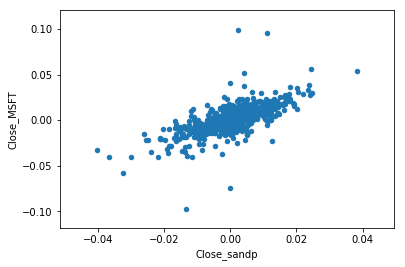

In [26]:
df_final.plot('Close_sandp', 'Close_MSFT', kind='scatter')
plt.show()

In [32]:
x = df_final['Close_sandp'].values[1:][:,None]
y = df_final['Close_MSFT'].values[1:][:,None]

## Scikit-Learn Method

In [33]:
x.shape, y.shape

((780, 1), (780, 1))

Model parameters are: [0.0003845] [[1.19160762]]


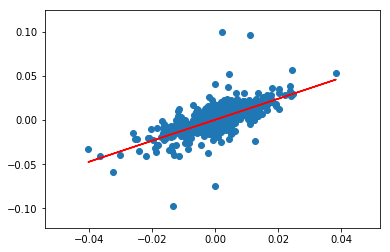

In [40]:
model = LinearRegression()
model.fit(x, y)
print('Model parameters are:', model.intercept_, model.coef_)

y_pred = model.predict(x)
plt.scatter(x,y)
plt.plot(x, y_pred, 'r')
plt.show()

In [42]:
x_t = theano.shared(x.squeeze())
y_t = theano.shared(y.squeeze())

n_samples=500

with pm.Model() as model:
    α = pm.Normal('α', mu=0, sd=1)
    β = pm.Normal('β', mu=0, sd=1)
    regression = α+β*x_t

    sd = pm.Uniform('sd', 0, 1)
    likelihood = pm.Normal('y', mu=regression, sd=sd, observed=y_t)
    trace = pm.sample(n_samples)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, β, α]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:02<00:00, 1448.77draws/s]
The acceptance probability does not match the target. It is 0.9068457916439003, but should be close to 0.8. Try to increase the number of tuning steps.


In [44]:
trace['α'].shape

(2000,)

In [45]:
a_mean = trace['α'].mean(axis=0)
b_mean = trace['β'].mean(axis=0)

y_pred = a_mean + b_mean*x

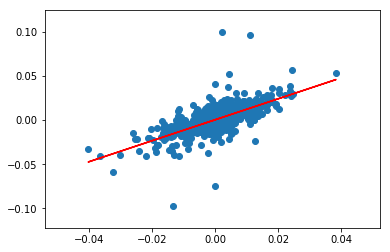

In [47]:
plt.scatter(x, y)
plt.plot(x, y_pred, 'r')
plt.show()

In [48]:
a_mean = trace['α']
b_mean = trace['β']

y_pred = a_mean + b_mean*x
y_pred.shape

(780, 2000)

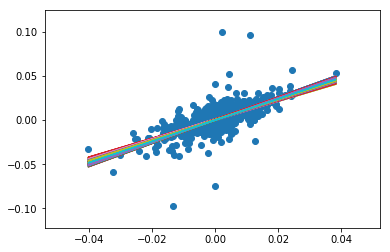

In [50]:
idx = np.random.choice(len(y_pred), 200)

plt.scatter(x, y)
for i in idx:
    plt.plot(x, y_pred[:,i])

plt.show()

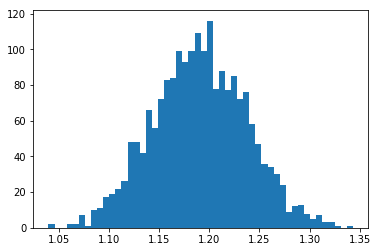

In [52]:
plt.hist(trace['β'], 50)
plt.show()

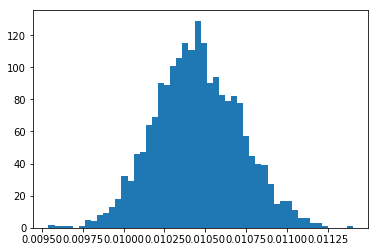

In [51]:
plt.hist(trace['sd'], 50)
plt.show()